# Spectral Embedding: MNIST Handwritten Digits

a.k.a. Laplacian Eigenmaps

(1797, 64)


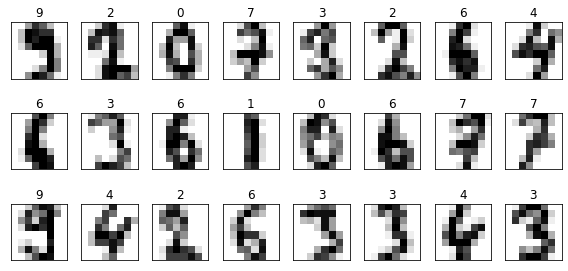

In [1]:
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import offsetbox
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import numpy as np
import random

X, y = load_digits(return_X_y=True)
print(X.shape)
random.seed(0)

rows, cols = 3, 8
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row',
                       subplot_kw=dict(xticks=[], yticks=[]),
                       figsize=(8,4))

for row in range(rows):
    for col in range(cols):
        n = np.random.randint(1796)+1    # show random samples
        im = ax[row, col].imshow(X[n].reshape((8,8)), cmap=plt.cm.gray_r)
        ax[row, col].set_title(y[n])

plt.tight_layout()
plt.show()

We'll use only 40% of the data to illustrate isomap embedding.

In [2]:
X2, _, y2,_ = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X2 = MinMaxScaler().fit_transform(X2)

print(X2.shape)
print(y2.shape)

(718, 64)
(718,)


## Define the kNN graph and Spectral Embedding classes

In [3]:
class knnGraph:
    def __init__(self, X, metric='euclidean', k=5):
        self.X = X
        self.k = k
        self.metric = metric
        
        # Get the pairwise distances
        D = pairwise_distances(self.X, self.X, 
                               metric=metric)
        
        # Set the distance of non-adjacent pts to 0
        for i in range(len(X)):
            D[i, D[i,:] > D[i,np.argsort(D[i,:])[k]]] = 0
        
        # Ensure that D is symmetric (knn graph is undirected)
        D = np.maximum(D, D.T)
        
        self.D = D

class SpectralEmbed:
    def __init__(self, metric='euclidean', k=5):
        self.metric = metric
        self.k = k
        
    def fit_transform(self, X):
        
        # Create an instance of kNN graph
        kNNG = knnGraph(X, metric=self.metric, k=self.k)
        
        self.kNNG = kNNG
        self.X = X
        
        # Compute the weights (adjacency) matrix
        W = np.minimum(kNNG.D, np.ones(kNNG.D.shape))
        
        # Compute the degree matrix
        D = np.diag(np.sum(W, axis=0))
        
        # Compute the graph Laplacian
        L = D - W
        
        self.L = L
        self.D = D
        self.W = W
        
        # Solve the generalized eig problem (use scipy.linalg.eigh)
        eigvals, eigvecs = eigh(L, D)
        
        # Sort the eigenvalues in ascending order
        idx = np.argsort(eigvals)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
                
        # Return the scores
        scores = eigvecs[:,1:3]
        return scores

## Perform Spectral Embedding

In [4]:
spec = SpectralEmbed(metric='euclidean', k=120)
scores = spec.fit_transform(X2)

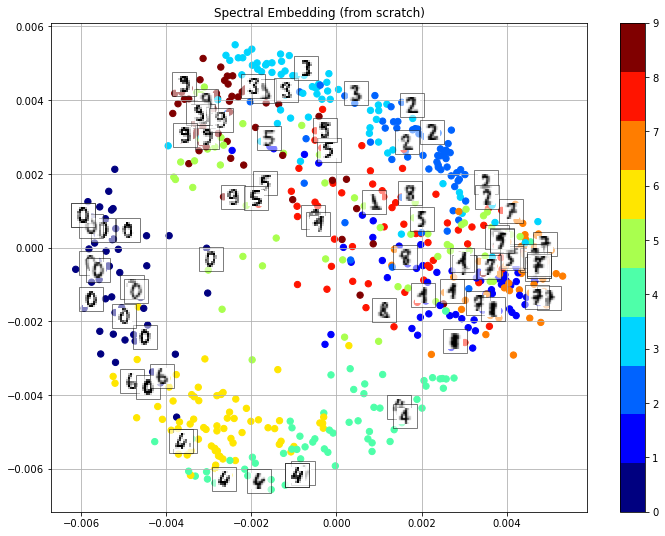

In [5]:
# Visualize the 2D embedding
fig, ax = plt.subplots(figsize=(12, 9))

for i in np.random.randint(len(y2),size=80):
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(X2[i].reshape((8,8)), 
                                                              cmap=plt.cm.gray_r, zoom=2), 
                                        xy=scores[i,:], xybox=scores[i,:], bboxprops=dict(alpha=0.5))
    ax.add_artist(imagebox)

plt.scatter(scores[:,0], scores[:,1], c=y2, s=40,
            cmap=plt.cm.get_cmap("jet", 10))
plt.title('Spectral Embedding (from scratch)')
plt.colorbar()
plt.grid()
plt.show()

## Compare with sklearn Spectral Embedding

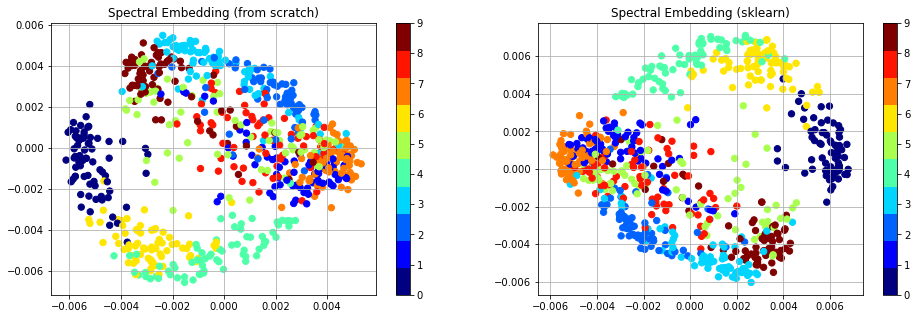

In [6]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2, n_neighbors=120)
scores2 = embedding.fit_transform(X2)


plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.scatter(scores[:,0], scores[:,1], c=y2, s=40,
            cmap=plt.cm.get_cmap("jet", 10))
plt.title('Spectral Embedding (from scratch)')
plt.colorbar()
plt.grid()

plt.subplot(122)
plt.scatter(scores2[:,0], scores2[:,1], c=y2, s=40,
            cmap=plt.cm.get_cmap("jet", 10))
plt.title('Spectral Embedding (sklearn)')
plt.colorbar()
plt.grid()
plt.show()